# POC Insect Egg Detection

Based on the initial images, stem borer egg has some unique properties that can be used in order to identify its presence on rice plant images. Here are some of the steps you can do to segment the image.

You can also use the following resource:

- https://medium.com/featurepreneur/colour-filtering-and-colour-pop-effects-using-opencv-python-3ce7d4576140
- https://medium.com/kitepython/image-segmentation-with-python-213b3b016e7d
- https://stackoverflow.com/questions/47483951/how-to-define-a-threshold-value-to-detect-only-green-colour-objects-in-an-image
- https://github.com/lukepolson/youtube_channel/blob/main/Python%20Tutorial%20Series/image_processing1.ipynb

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics
from skimage.segmentation import clear_border

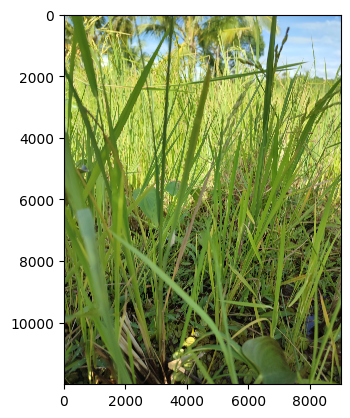

In [4]:
raw_img = cv2.imread("img/stem1.jpg")
plt.imshow(cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB))

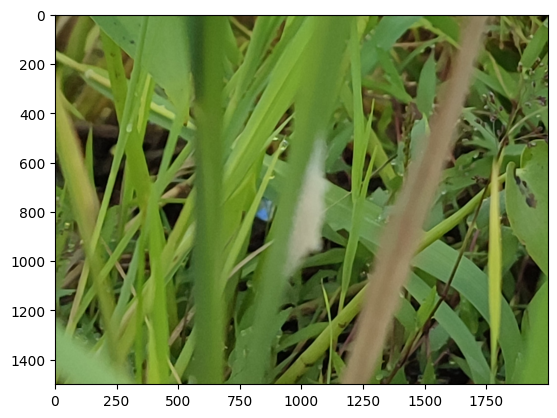

In [5]:
plt.imshow(cv2.cvtColor(raw_img[6500:8000, 2500:4500], cv2.COLOR_BGR2RGB))

The eggs are often attached in sides or bent parts of the rice plant. They are a bit elongated in shape probably easy to distinguish when we use thresholding.

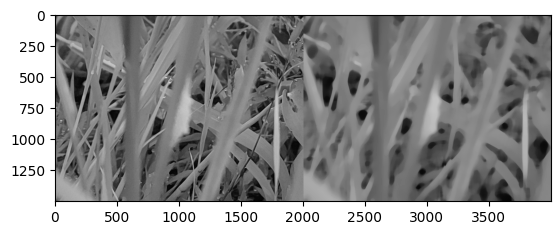

In [6]:
egg = raw_img[6500:8000, 2500:4500]
# egg = img[10700:11800, 3500:4500]
egg_gray_raw = cv2.cvtColor(egg, cv2.COLOR_BGR2GRAY)
# 51 seems a good value for blur
egg_gray = cv2.medianBlur(egg_gray_raw, 51)
plt.imshow(np.hstack((egg_gray_raw, egg_gray)), cmap="gray")

Text(0, 0.5, 'Count')

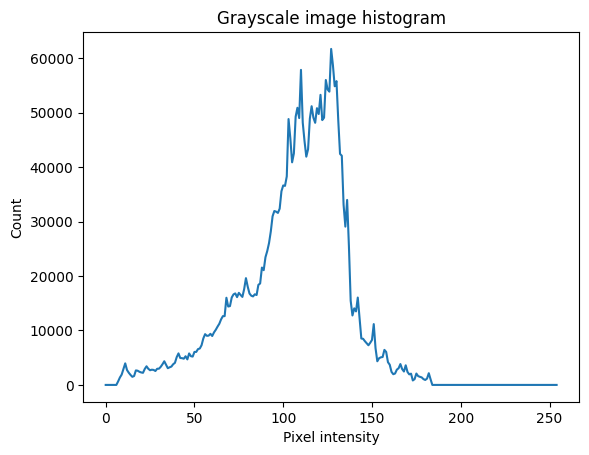

In [7]:
counts, vals = np.histogram(egg_gray, bins=range(2 ** 8))
plt.plot(range(0, (2 ** 8) - 1), counts)
plt.title("Grayscale image histogram")
plt.xlabel("Pixel intensity")
plt.ylabel("Count")

### Note

Probably worth exploring and looking into histogram differences of other segments of the image.

Will look into setting threshold to make am ask to isolate the white/grayhish part that is the egg. There's a slight bump in the 160-190 range.

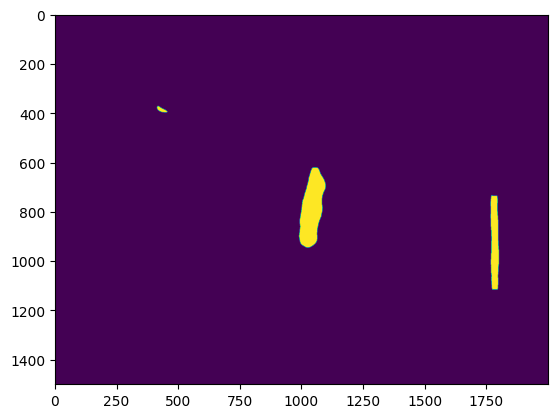

In [8]:
thresh = 165
mask = egg_gray > thresh
plt.imshow(mask)

### Notes

The actual egg can be segmented properly but there are other elements in the image that can be mis classified. We can use the following to solve this.

- Use machine learning models and train the images directly
- Apply additional image segemntation technique and find properties that can differentiate the eggs


## Check the procedure on all parts of the image

In [9]:
height, width, _ = raw_img.shape
split_height = 2000
split_width = 1000

In [10]:
def generate_mask(img, median_filter:int = 51, mask_thresh:int = 165):
    """
    Converts the image to b&w, run filter
    Apply thresholding, see if we can extract feature.
    """
    filtered = cv2.medianBlur(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), median_filter)
    return filtered > mask_thresh

def slice_image(img: np.array, w: int, h: int, split_w: int, split_h: int):
    """
    Generator that returns the image slices
    """
    for y in range(0, h, split_h):
        for x in range(0, w, split_w):
            y1 = y + split_h
            x1 = x + split_w
            yield img[y:y1, x:x1]
            
def display_all(all_image):
    _, axs = plt.subplots(6, 9, figsize=(15, 15))
    axs = axs.flatten()
    for _msk, ax in zip(all_image, axs):
        ax.imshow(_msk)
    plt.show()

In [11]:
# Generate mask
raw_slices = slice_image(raw_img, width, height, split_width, split_height)
mask = np.array([generate_mask(_img) for _img in raw_slices])
mask.shape

(54, 2000, 1000)

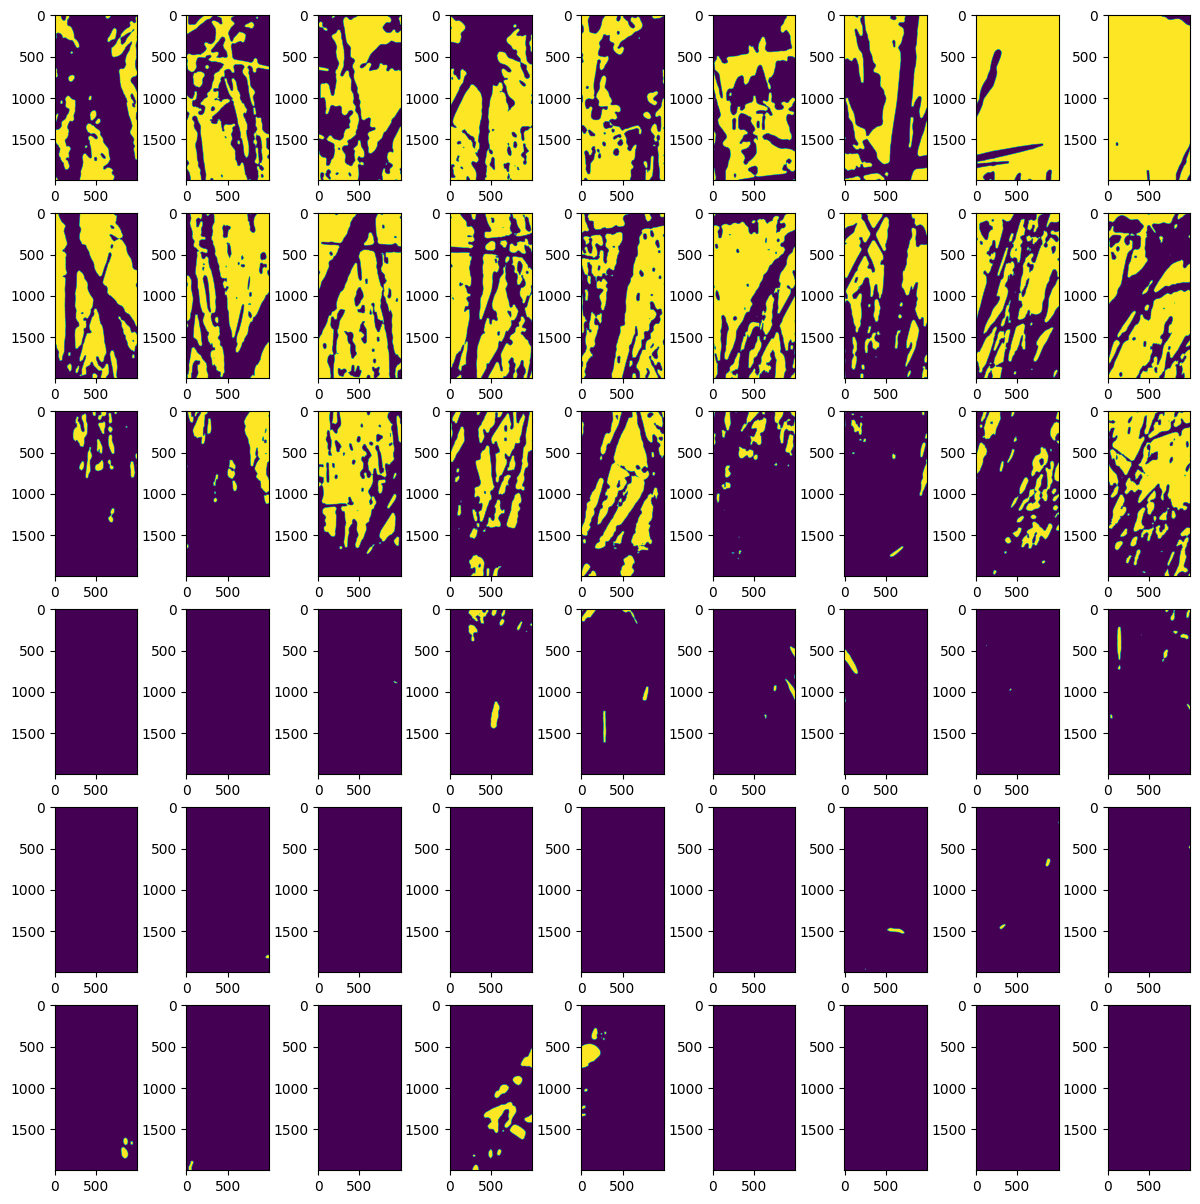

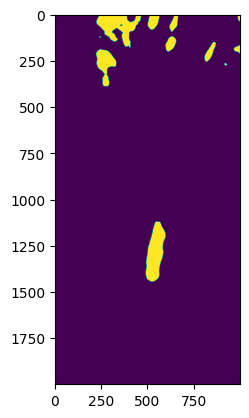

In [12]:
display_all(mask)
plt.imshow(mask[30])

### Notes

Upon applying filters and threshold, we can assume that the upper part of the images tend to show more sky and glare and the lower part has the darker area. Thus we can have the following assumptions:

- Stem borer eggs are typically under or in the side of the upper part of the leaf. Therefore, all the detection that can happen in the lower portions can be ignored.
- The upper where we can see the sky produces a lot of white background and glare. We can also ignore this part and just focus on the middle section of the image.

Caveats:

- Stem borer egs can also be located in the upper part of time image depending on the angle and the condition of the capture environment.
- The upper middle portion of the image can be prone to misdetection because of the way on how we try to extract the stem borer egg object from the image. (need to improve on this)

In [13]:
mask = np.vectorize(clear_border, signature='(n,m)->(n,m)')(mask)

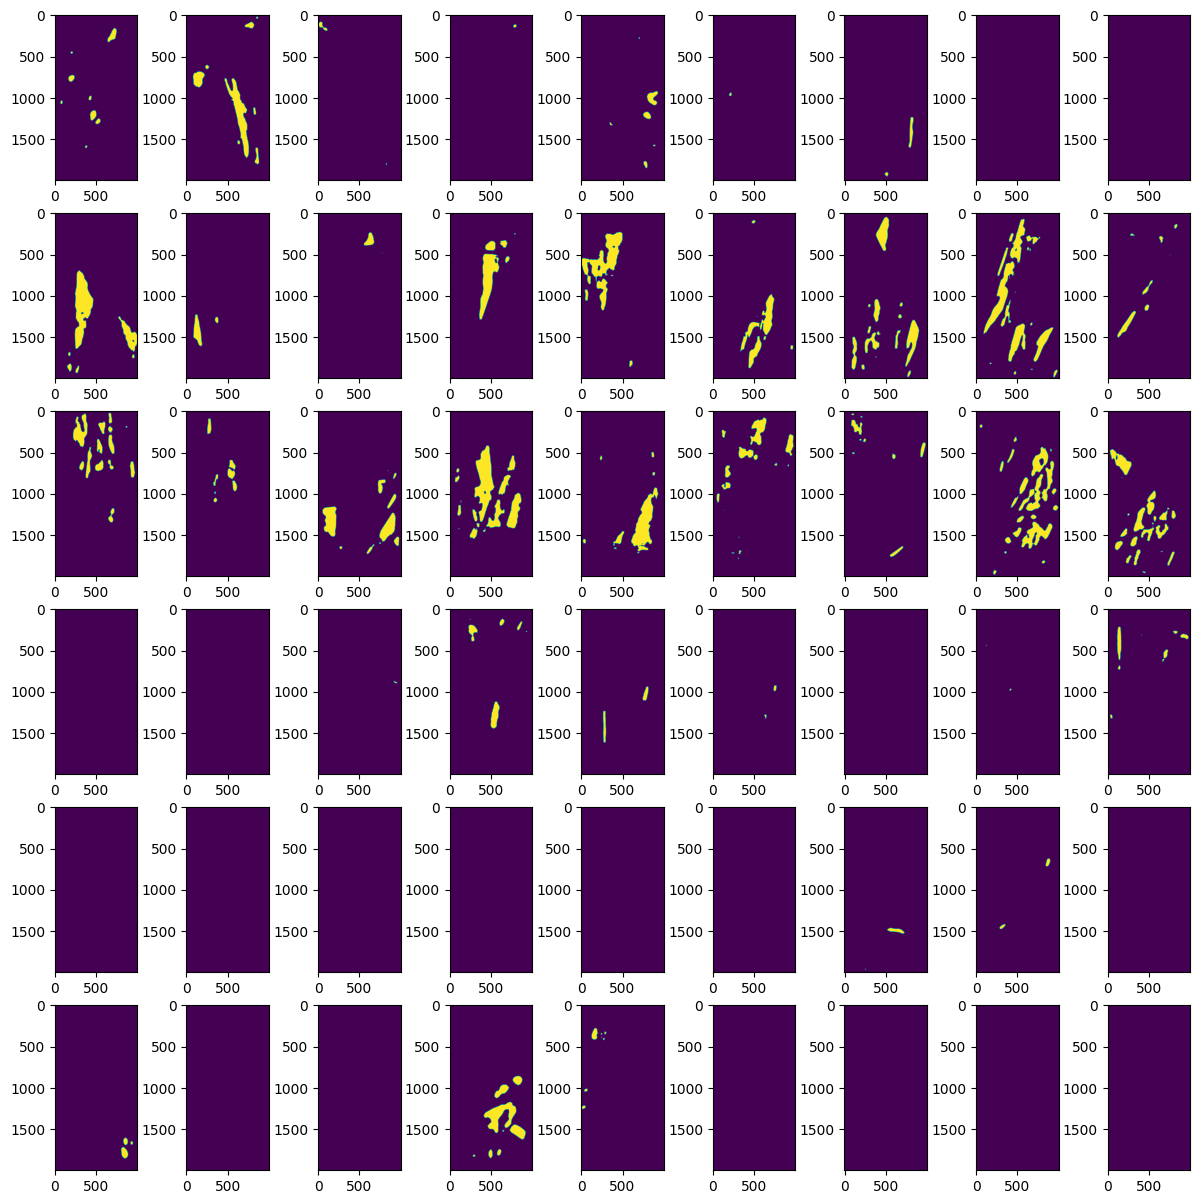

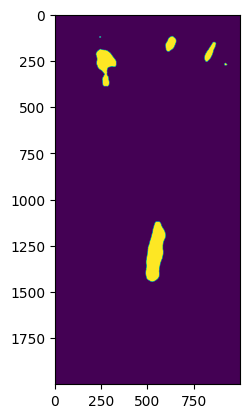

In [14]:
display_all(mask)
plt.imshow(mask[30])